### Connection  to Drive and Importing libraries

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/UNIVERSITA/ANN/ANNDL/Homework1



Mounted at /gdrive
/gdrive/MyDrive/UNIVERSITA/ANN/ANNDL/Homework1


In [142]:
from function_folder.librarys import *
import function_folder
importlib.reload(function_folder.librarys)

librerie in caricamento_mse
2.14.0
librerie caricate


<module 'function_folder.librarys' from '/gdrive/MyDrive/UNIVERSITA/ANN/ANNDL/Homework1/function_folder/librarys.py'>

## Ricaricare i moduli

importlib.reload(nome_modulo)

### Load and process the dataset

(5200, 96, 96, 3)
(5200,)


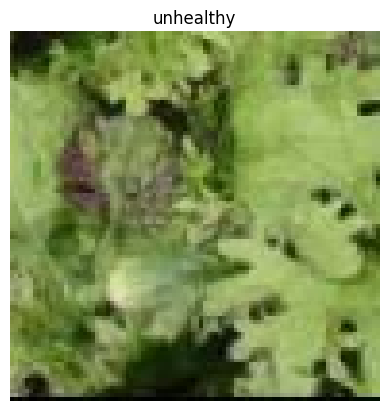

In [4]:
from function_folder.import_data_and_viusalization import file_upload
npzobj = file_upload()

X = npzobj['data']  # X is a np array that contains images
y = npzobj['labels'] # Y is a np array that contains labels

### Splitting the dataset

In [5]:
import function_folder
importlib.reload(function_folder.splitter)

AttributeError: ignored

In [6]:
from function_folder.splitter import splitting_function
X_train, X_val,X_test, y_train, y_val,y_test = splitting_function(X,y)

X_train shape: (4212, 96, 96, 3), y_train shape: (4212, 2)
X_val shape: (468, 96, 96, 3), y_val shape: (468, 2)
X_test shape: (520, 96, 96, 3), y_test shape: (520, 2)


## Model

In [152]:
import function_folder.models.model0 as mod0

importlib.reload(mod0)
#mobile = mod0.MobileNetV2()
vgg = mod0.VGG16_max()

chosen_model = vgg

# Display the model architecture with input shapes
# tfk.utils.plot_model(chosen_model, show_shapes=True)

### Data Augmentation

### number of neurons

In [153]:
num_neurons = 64

In [161]:
# Use the supernet as feature extractor, i.e. freeze all its weigths
chosen_model.trainable = False

# Create an input layer with shape (96, 96, 3)
inputs = tfk.Input(shape=(96, 96, 3))

### DATA AUGMENTATION

preprocessing = tf.keras.Sequential([
  tfkl.RandomFlip("horizontal_and_vertical"),
  tfkl.RandomTranslation(0.2,0.2),
  tfkl.RandomRotation(0.2),
], name='preprocessing')


preprocessed_layer = preprocessing(inputs)
###


# Connect  to the input
x = chosen_model(preprocessed_layer)

### NEW LAYERS
x = tfkl.Flatten()(x)
x = tfkl.Dense(num_neurons,activation = "relu", kernel_initializer=tfk.initializers.HeUniform(seed=seed))(x)

dropout_rate = 1/6
dropout = tfkl.Dropout(dropout_rate, seed=seed)(x)

last_layer = dropout
###

outputs = tfkl.Dense(2, activation='softmax')(last_layer)

# Create a Model connecting input and output
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

# Display model summary
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 preprocessing (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_16 (Flatten)        (None, 512)               0         
                                                                 
 dense_32 (Dense)            (None, 64)                32832     
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_33 (Dense)            (None, 2)                 130   

### Callbacks

#### Hyperparameters callbacks

In [155]:
lr_patience = 5
patience = 20
monitor = 'val_accuracy'

In [156]:
lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor=monitor,     # Metric to monitor (validation mean squared error in this case)
    patience=lr_patience,  # Number of epochs with no improvement after which learning rate will be reduced
    factor=0.999,          # Factor by which the learning rate will be reduced (0.999 in this case)
    mode='min',            # Mode to decide when to reduce learning rate ('min' means reduce when metric stops decreasing)
    min_lr=1e-5            # Minimum learning rate
)

early_stopping= tfk.callbacks.EarlyStopping(monitor=monitor, mode='max', patience=patience, restore_best_weights=True)
callbacks = [early_stopping,lr_scheduler]

#### hyperparameters training

In [157]:
epochs = 200
batch_size = 64


### Training

In [162]:
# Train the model
tl_history = tl_model.fit(
    x = preprocess_input(X_train*255), # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (preprocess_input(X_val*255), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = callbacks
).history

Epoch 1/200
43/66 [==================>...........] - ETA: 1s - loss: 3.8559 - accuracy: 0.5752

KeyboardInterrupt: ignored

### K FOLD CROSS VALIDATION

In [163]:
# Define the number of folds for cross-validation
num_folds = 2

# Initialize lists to store training histories, scores, and best epochs
histories = []
scores = []
best_epochs = []

# Create a KFold cross-validation object
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)


# Loop through each fold
for fold_idx, (train_idx, valid_idx) in enumerate(kfold.split(X_val, y_val)):

  print("Starting training on fold num: {}".format(fold_idx+1))

  # Build a new dropout model for each fold
  k_model = tl_model

  # Train the model on the training data for this fold
  history = k_model.fit(
    x = X_val[train_idx],  # Utilizza l'indicizzazione di NumPy invece di .iloc
    y = y_val[train_idx],  # Utilizza l'indicizzazione di NumPy invece di .iloc
    validation_data=(X_val[valid_idx], y_val[valid_idx]),  # Utilizza l'indicizzazione di NumPy invece di .iloc
    batch_size = batch_size,
    epochs = epochs,
    callbacks = callbacks,
    verbose = 0
  ).history

# ... (resto del tuo codice)

  # Evaluate the model on the validation data for this fold
  score = k_model.evaluate(X_val[valid_idx], y_val[valid_idx], verbose=0)
  scores.append(score[1])

  # Calculate the best epoch for early stopping
  best_epoch = len(history['loss']) - patience
  best_epochs.append(best_epoch)

  # Store the training history for this fold
  histories.append(history)



Starting training on fold num: 1
Starting training on fold num: 2


MSE
Mean: 0.7308
Std:  0.0214


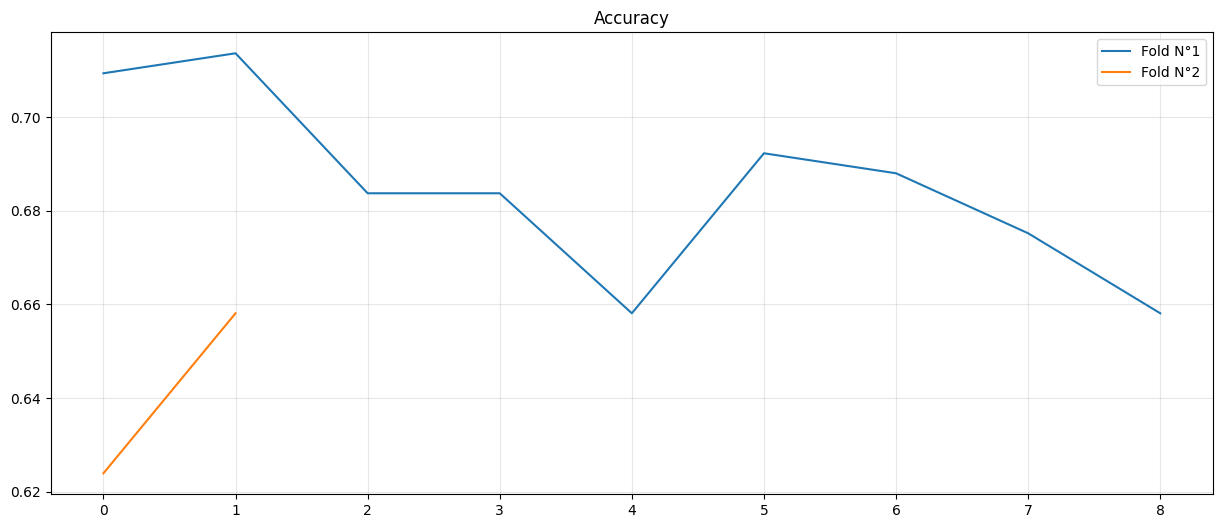

Best average epoch: 5


In [166]:
##############
# Define a list of colors for plotting
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# Print mean and standard deviation of MSE scores
print("MSE")
print(f"Mean: {np.mean(scores).round(4)}\nStd:  {np.std(scores).round(4)}")

# Create a figure for MSE visualization
plt.figure(figsize=(15,6))

# Plot MSE for each fold
for fold_idx in range(num_folds):
  plt.plot(histories[fold_idx]['accuracy'][:-patience], color=colors[fold_idx], label=f'Fold N°{fold_idx+1}')
  plt.title('Accuracy')
  plt.legend(loc='upper right')
  plt.grid(alpha=.3)

# Show the plot
plt.show()
#############

# Calculate the average best epoch
avg_epochs = int(np.mean(best_epochs))
print(f"Best average epoch: {avg_epochs}")

In [168]:
print(histories[fold_idx]['accuracy'])

[0.6239316463470459, 0.6581196784973145, 0.6452991366386414, 0.6752136945724487, 0.6239316463470459, 0.6581196784973145, 0.6495726704597473, 0.6666666865348816, 0.6538461446762085, 0.6196581125259399, 0.6794871687889099, 0.6538461446762085, 0.692307710647583, 0.692307710647583, 0.6410256624221802, 0.7051281929016113, 0.7008547186851501, 0.6623931527137756, 0.6709401607513428, 0.692307710647583, 0.7264957427978516, 0.7051281929016113]


### Plotting

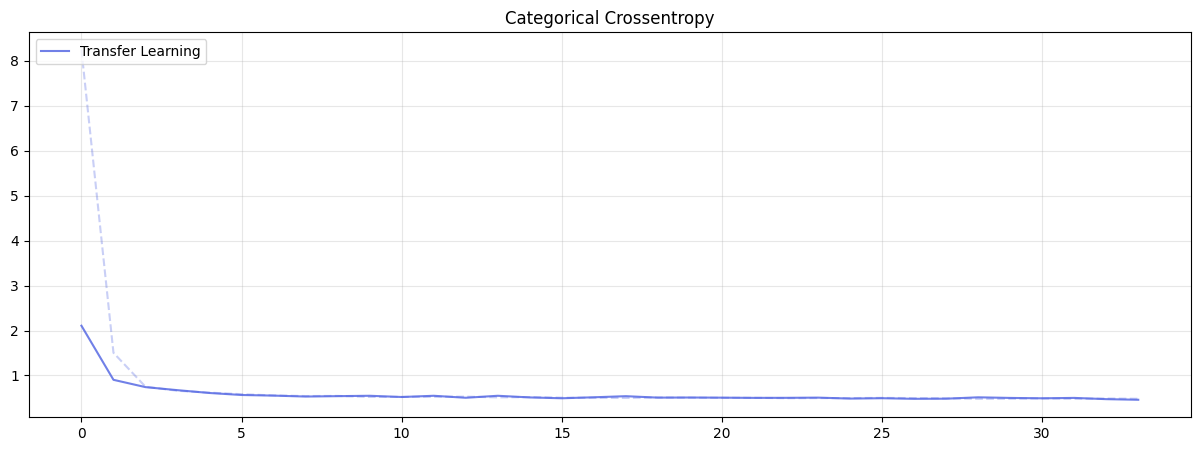

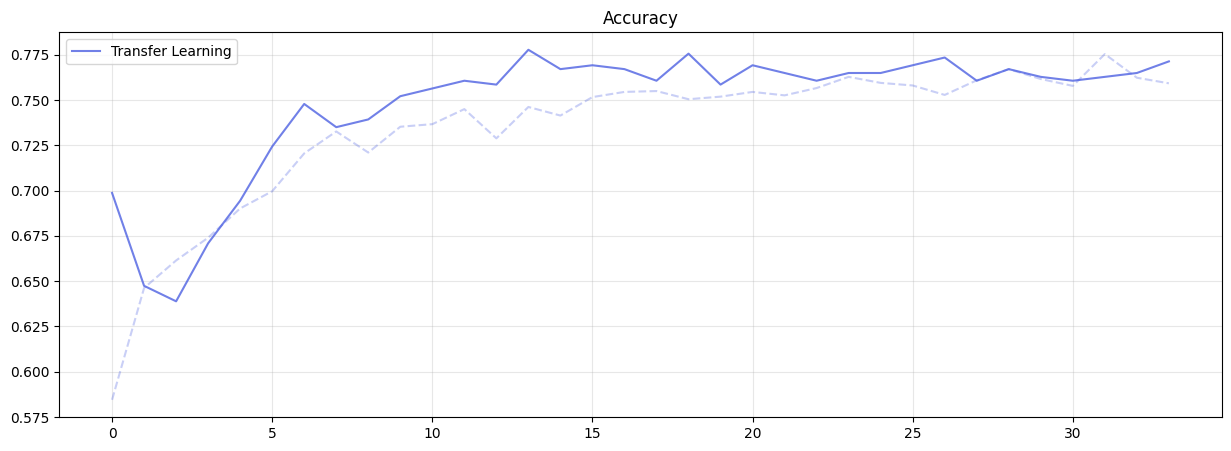

In [137]:
from function_folder.plotting.history_plot import plot_history
importlib.reload(function_folder.plotting.history_plot)
plot_history(tl_history)

## Evaluation on test set




In [136]:
test_loss, test_accuracy = tl_model.evaluate(preprocess_input(X_test*255),y_test)

17/17 [==============================] - 2s 54ms/step - loss: 0.5386 - accuracy: 0.7385


## Save the model

In [79]:
# Save the best model
tl_model.save('Jarvis_0')
del tl_model

## Load the Model

In [ ]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('Jarvis_0')
ft_model.summary()

## Fine Tuning

#### Number of layers to freeze

In [80]:
N = 133
layer_to_freeze = 'mobilenetv2_1.00_96'
ft_model = tl_model


In [92]:
# Set all MobileNetV2 layers as trainable
ft_model.get_layer(layer_to_freeze).trainable = True
for i, layer in enumerate(ft_model.get_layer(layer_to_freeze).layers):
   print(i, layer.name, layer.trainable)


# Freeze first N layers, e.g., until the 133rd one

for i, layer in enumerate(ft_model.get_layer(layer_to_freeze).layers[:N]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer(layer_to_freeze).layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()


# Compile the model
ft_model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics='accuracy')

0 input_1 True
1 Conv1 True
2 bn_Conv1 True
3 Conv1_relu True
4 expanded_conv_depthwise True
5 expanded_conv_depthwise_BN True
6 expanded_conv_depthwise_relu True
7 expanded_conv_project True
8 expanded_conv_project_BN True
9 block_1_expand True
10 block_1_expand_BN True
11 block_1_expand_relu True
12 block_1_pad True
13 block_1_depthwise True
14 block_1_depthwise_BN True
15 block_1_depthwise_relu True
16 block_1_project True
17 block_1_project_BN True
18 block_2_expand True
19 block_2_expand_BN True
20 block_2_expand_relu True
21 block_2_depthwise True
22 block_2_depthwise_BN True
23 block_2_depthwise_relu True
24 block_2_project True
25 block_2_project_BN True
26 block_2_add True
27 block_3_expand True
28 block_3_expand_BN True
29 block_3_expand_relu True
30 block_3_pad True
31 block_3_depthwise True
32 block_3_depthwise_BN True
33 block_3_depthwise_relu True
34 block_3_project True
35 block_3_project_BN True
36 block_4_expand True
37 block_4_expand_BN True
38 block_4_expand_relu Tru

In [93]:
# Fine-tune the model
ft_history = ft_model.fit(
    x = preprocess_input(X_train*255), # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (preprocess_input(X_val*255), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = callbacks
).history

Epoch 1/200
66/66 [==============================] - 8s 52ms/step - loss: 0.6913 - accuracy: 0.6045 - val_loss: 0.7123 - val_accuracy: 0.6154 - lr: 1.0000e-05
Epoch 2/200
66/66 [==============================] - 2s 34ms/step - loss: 0.6292 - accuracy: 0.6595 - val_loss: 0.7006 - val_accuracy: 0.6154 - lr: 1.0000e-05
Epoch 3/200
66/66 [==============================] - 2s 37ms/step - loss: 0.5920 - accuracy: 0.6933 - val_loss: 0.6888 - val_accuracy: 0.5876 - lr: 1.0000e-05
Epoch 4/200
66/66 [==============================] - 2s 31ms/step - loss: 0.5653 - accuracy: 0.7189 - val_loss: 0.6822 - val_accuracy: 0.5855 - lr: 1.0000e-05
Epoch 5/200
66/66 [==============================] - 2s 32ms/step - loss: 0.5477 - accuracy: 0.7329 - val_loss: 0.6766 - val_accuracy: 0.5876 - lr: 1.0000e-05
Epoch 6/200
66/66 [==============================] - 2s 31ms/step - loss: 0.5268 - accuracy: 0.7493 - val_loss: 0.6714 - val_accuracy: 0.5897 - lr: 1.0000e-05
Epoch 7/200
66/66 [===========================

## Plot

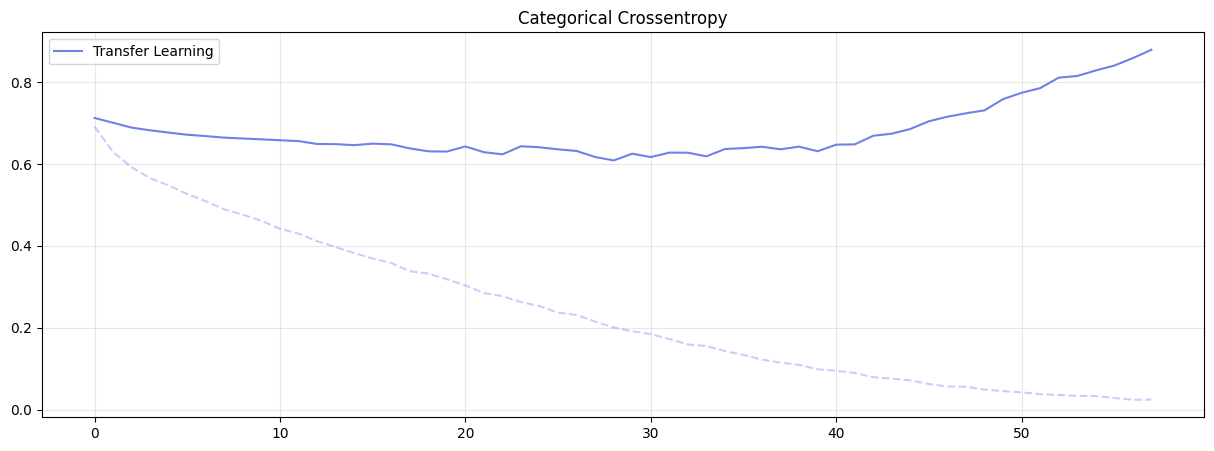

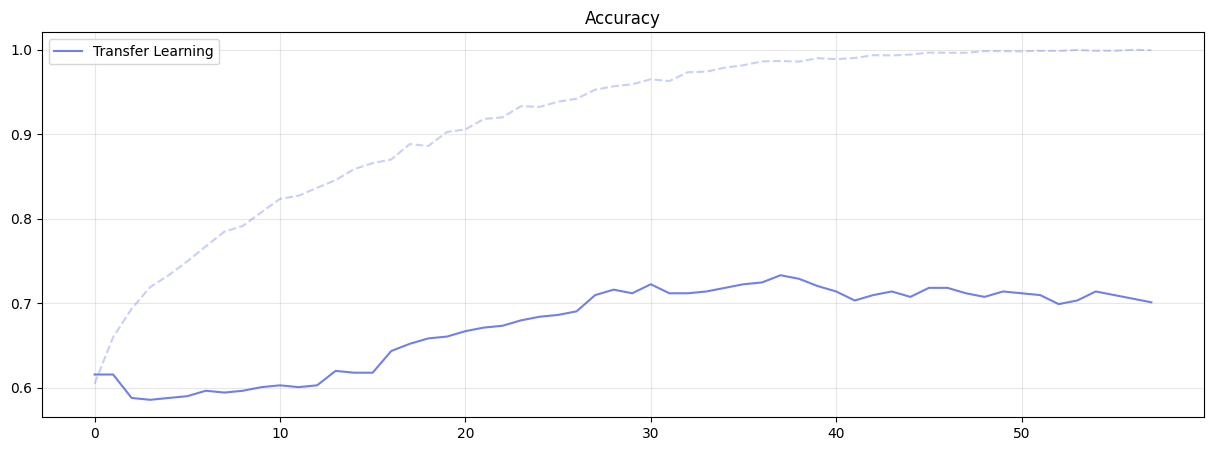

In [94]:
plot_history(ft_history)

### Evaluation on test set

In [104]:
# Evaluate the model on the test set
test_accuracy = ft_model.evaluate(preprocess_input(X_test*255),y_test)

17/17 [==============================] - 0s 17ms/step - loss: 0.6357 - accuracy: 0.7096
